# cuda:4

In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema, argrelmax
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import traceback
import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_num_threads(4)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value std id {STD:.3f}')
print(f'Train {TRAINLENGTH} Test {TEST} M {M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal length M=15000
Normalizing value max-min id 38.053
Normalizing value std id 7.912
Train 14000 Test 1000 M 15000


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

In [4]:
fpath = 'Dicts/diag_Lx.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts/models_Lx.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())

In [32]:
fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### The predictions below are purely from the refinement process in the paper.  There is no handpicking of models.

N=300   Error = 0.218770 KL-div = 0.449
N=50   Error = 0.202708 KL-div = 0.397
N=40   Error = 0.213677 KL-div = 0.501
N=30   Error = 0.207925 KL-div = 3.582
N=20   Error = 0.208396 KL-div = 0.795
N=10   Error = 0.221632 KL-div = 0.627


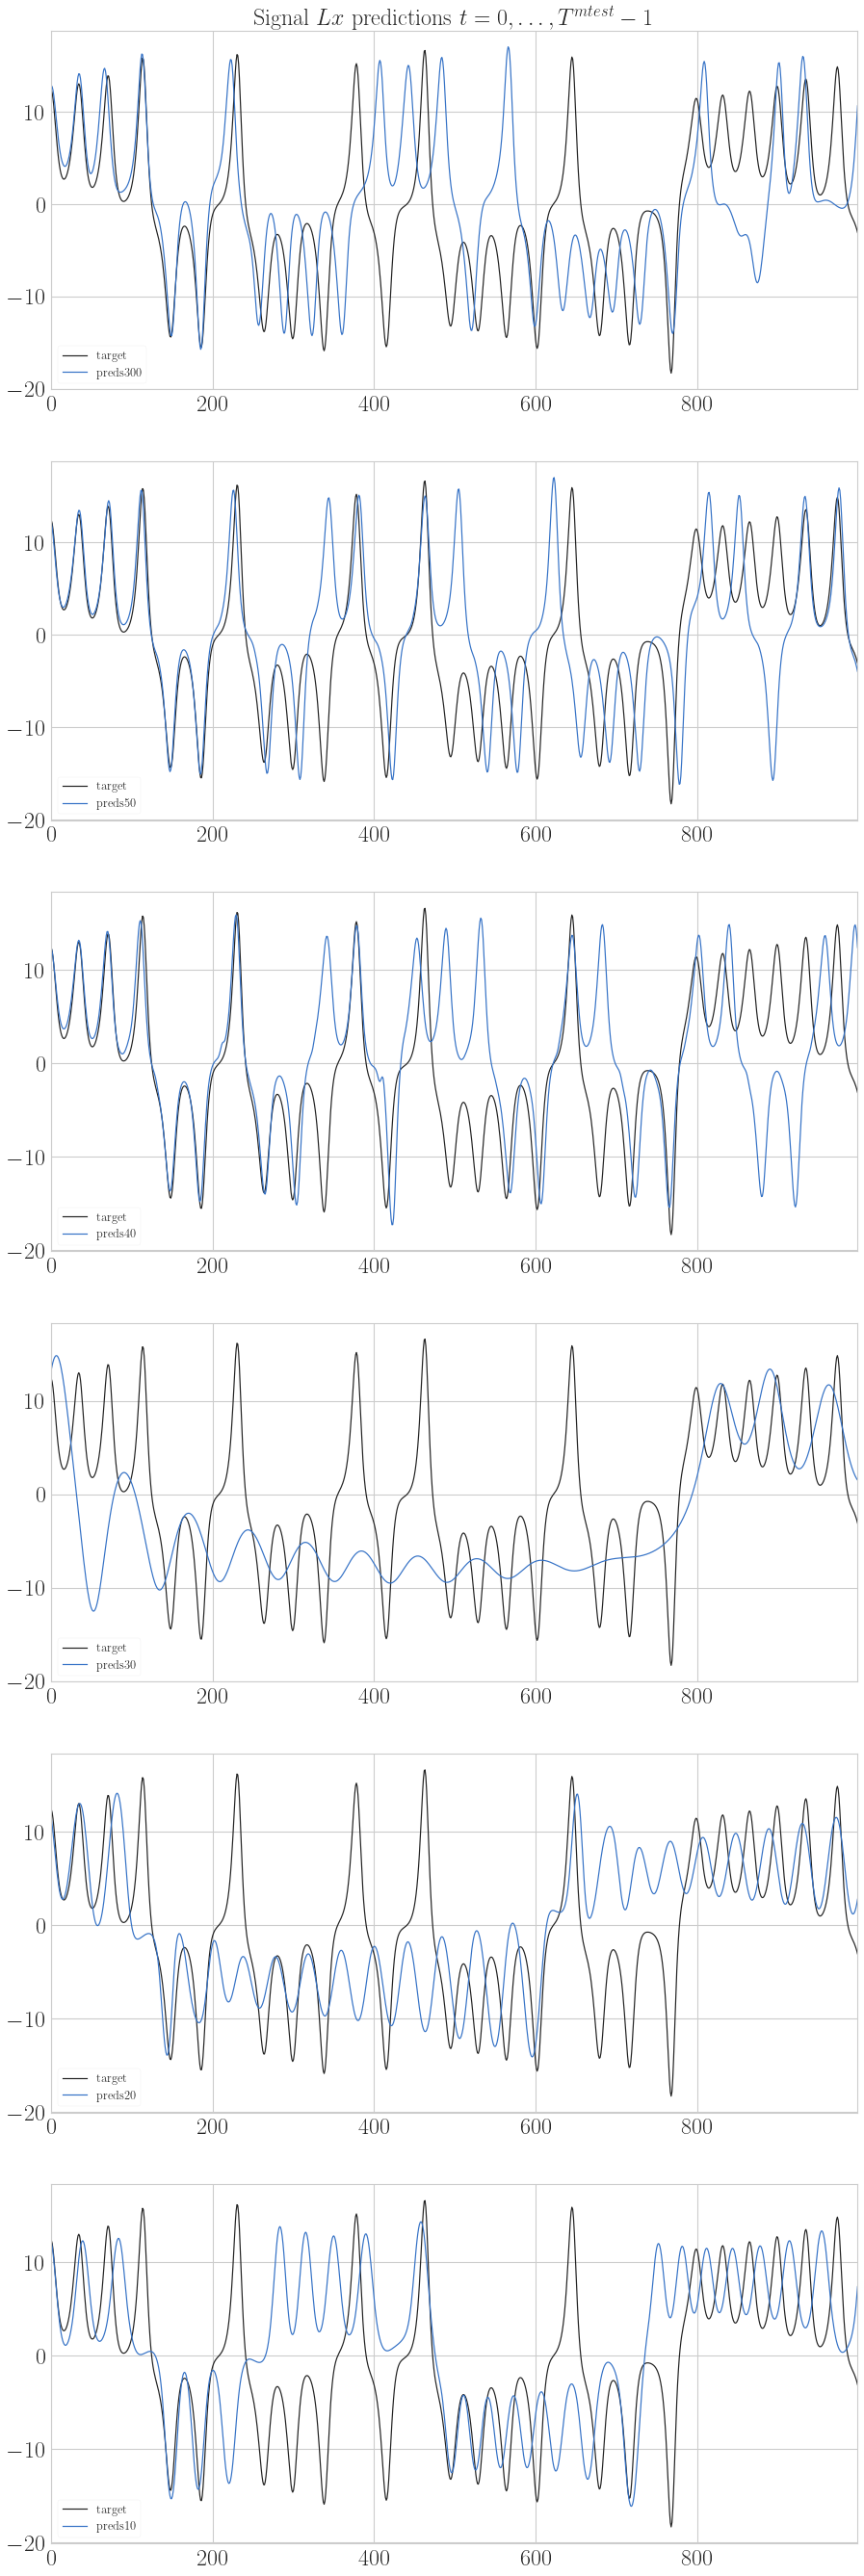

In [6]:
size = [300,50,40,30, 20,10]

Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST], color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    print(f'N={size[n]}   Error = {error_testset:3f} KL-div = {kl:.3f}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
             color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Get indicated rank to reduce to

Targeted reduced rank for N=300 is 20
Value v= 15 Tolerance 1e-15 Rho A 1.75
Alpha 0.492482409307395 --- Gamma 1.0

Targeted reduced rank for N=50 is 43
Value v= 16 Tolerance 1e-16 Rho A 0.987
Alpha 0.5091509864618499 --- Gamma 1.0

Targeted reduced rank for N=40 is 35
Value v= 15 Tolerance 1e-15 Rho A 1.191
Alpha 0.6297767659069773 --- Gamma 1.0

Targeted reduced rank for N=30 is 23
Value v= 16 Tolerance 1e-16 Rho A 1.002
Alpha 0.010325744358472791 --- Gamma 1.0

Targeted reduced rank for N=20 is 18
Value v= 16 Tolerance 1e-16 Rho A 1.136
Alpha 0.11787230192436339 --- Gamma 1.0

Targeted reduced rank for N=10 is 1
Value v= 0 Tolerance 1.0 Rho A 1.006
Alpha 0.03007283024595796 --- Gamma 1.0



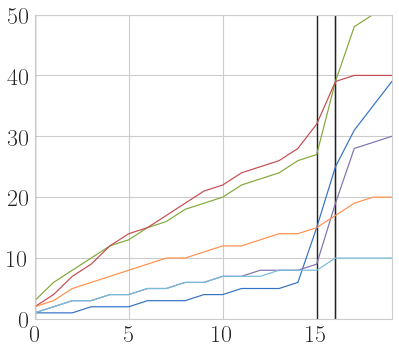

In [7]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

K = 1
L = 1
tols = [1/10**x for x in range(0,20)]
plt.figure()
for n in size:
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    #print(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(3)}')
    print(f'Alpha {a} --- Gamma {g}\n')
plt.ylim(0,50)
plt.show()

### Get time-step of divergence as measured by $R_{\mathbf{xy}}[k]$ correlation at each $t$

In [8]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


k=N=300 Trainingset min=0.878  threshold=0.834  Location=25
k=N=50 Trainingset min=0.99  threshold=0.940  Location=175
k=N=40 Trainingset min=0.984  threshold=0.935  Location=78
k=N=30 Trainingset min=0.859  threshold=0.816  Location=1
k=N=20 Trainingset min=0.896  threshold=0.851  Location=41
k=N=10 Trainingset min=0.593  threshold=0.563  Location=94


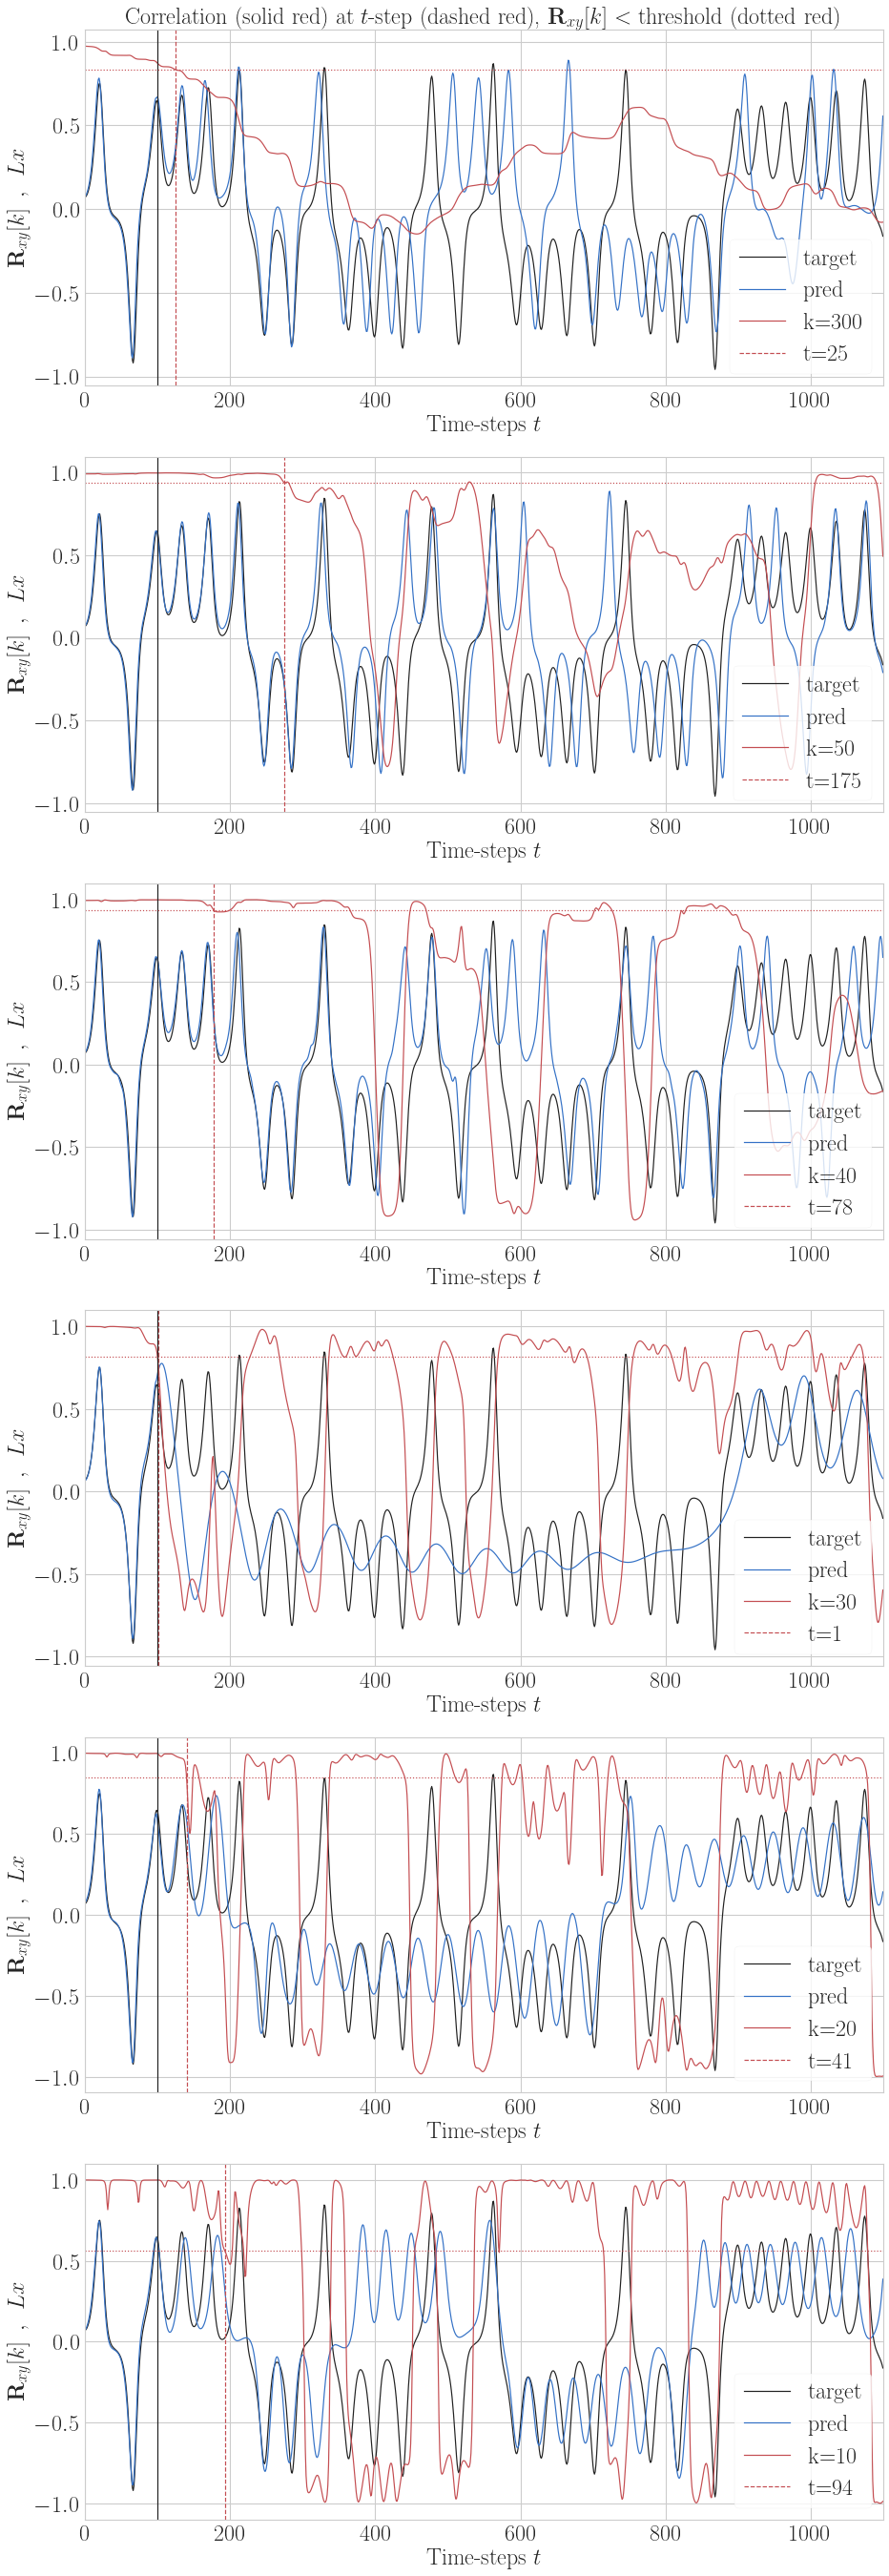

In [9]:
LEAD = 100
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos plot

In [22]:
from scipy.signal import argrelmax

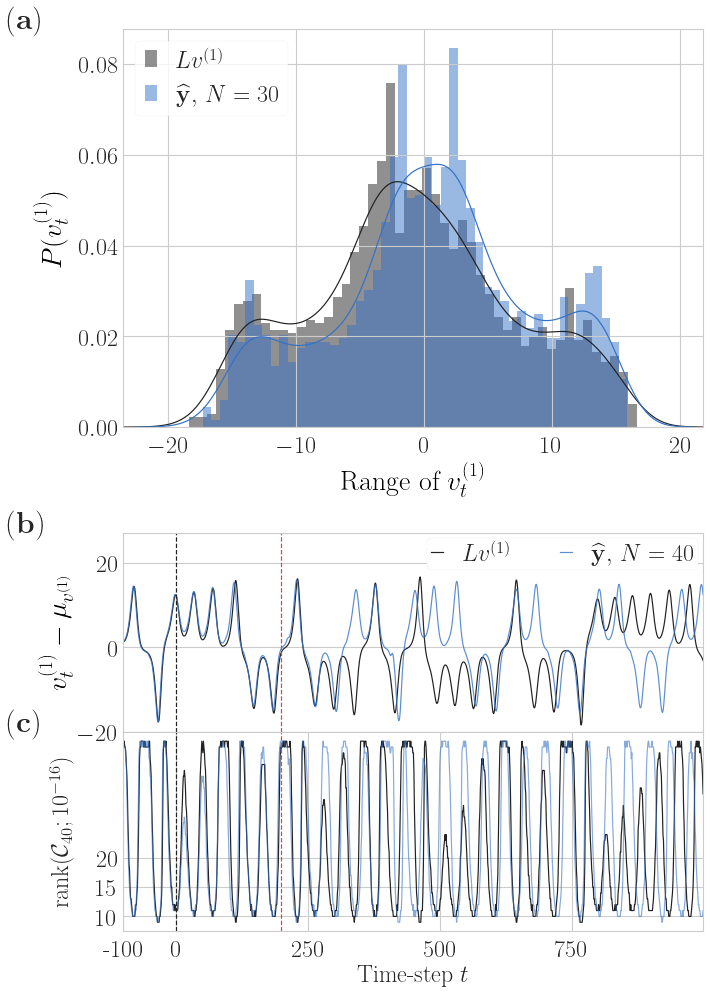

In [34]:
N = 40
K = 1
v = 10
pred = np.array(dict_models[str(N)]['Preds'])
start, end= 13900,15000
p = dict_models[str(N)]['Params']
mat = np.array(dict_models[str(N)]['Wnet'])
Wr, Wi = rca.get_mats(None, K,N, matrix=mat)
sig_rks = rca.rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end], N, K, tols[v])
pred_rks = rca.rank_along_trajectory( Wr, Wi, p[0], p[2],
                            pred[start:end],N, K, tols[v])

top,bottom  = 13900,15000
mu = .56018255




gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28


data_dict = {'y': signal[14000:],
             'yh30': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(1)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh30'],
             label='$\widehat{\mathbf{y}},\,N=30$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper left', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(1)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(1)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,15000
xax = [k for k in range(start,end)]
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=0)

ax2 = plt.subplot(gs1[0])
ax2.plot(xax,signal[start:end],'k', label=r'$Lv^{(1)}$')
ax2.plot(xax,pred[start:end],'b-', label='$\widehat{\mathbf{y}},\,N=40$', alpha = .8)
ax2.set_ylim(-20,27)
ax2.legend(loc='upper right',
           framealpha=1,
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)

ax2.set_ylabel(r'$v^{(1)}_t-\mu_{v^{(1)}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])


ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.plot(xax,sig_rks,
        color='k', label='$Lv^{(1)}$', alpha=1.)
ax3.plot(xax,pred_rks,
        color= 'b', label='$\widehat{\mathbf{y}}$', alpha=.6)
#ax3.set_ylim(10, 22)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{40};10^{-16})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')

ax3.set_xticks([13900,14000,14250,14500,14750])
ax3.set_xticklabels([-100,0,250,500,750])
ax3.set_yticks([10,15,20])

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14200, c='r',ls='dashed' )

ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14200, c='r',ls='dashed' )
plt.tight_layout()
plt.show()
#fig.savefig("../ChaosPlots/Lx_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)